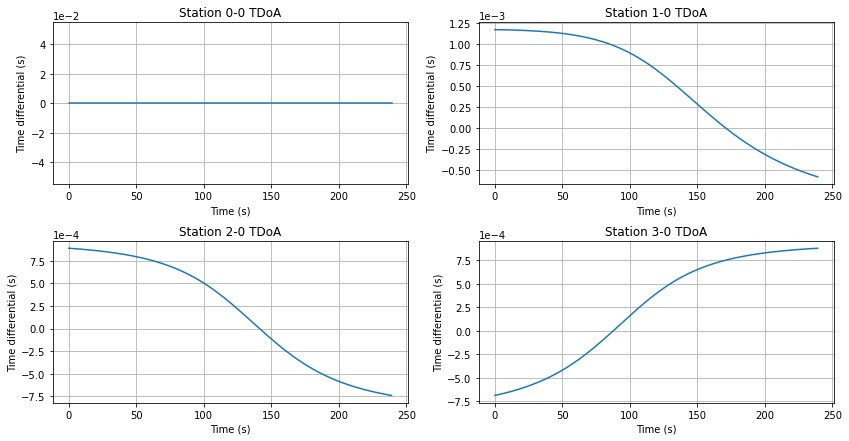

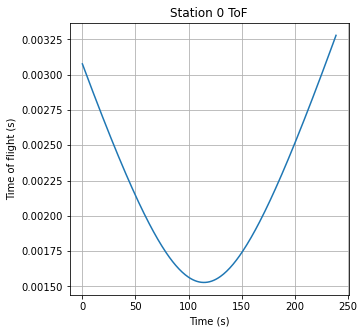

In [1]:
import time
import numpy as np
import argparse
import os

from astropy.time import Time   # Astropy 4.1rc1 is used

from orbdet.utils.utils import *
from orbdet.utils.utils_aux import *
from orbdet.utils.utils_vis import *

from scipy.optimize import fsolve

%matplotlib inline

np.random.seed(100)
np.set_printoptions(precision=4)

n_obs = 4

x_0, t_sec, x_sat_orbdyn_stm, x_obs_multiple, _ = get_example_scenario(id=3, frame='teme')
tdoa, tof = get_tdoa_simulated_approx(x_sat_orbdyn_stm, x_obs_multiple)
r, rr = range_range_rate(x_sat_orbdyn_stm, x_obs_multiple)

fig_1 = plt.figure(figsize=(14,7))

for i in range(n_obs):
    ax = fig_1.add_subplot(2, 2, i+1)
    ax.plot(t_sec, tdoa[i,:])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Time differential (s)')
    ax.grid(':')
    ax.title.set_text(f"Station {i}-0 TDoA")
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

fig_1.subplots_adjust(hspace=0.35)

fig_2 = plt.figure(figsize=(5,5))

ax = fig_2.add_subplot(1, 1, 1)
ax.plot(t_sec, tof[0,:])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Time of flight (s)')
ax.grid(':')
ax.title.set_text(f"Station 0 ToF")

In [14]:
def equations_tdoa(vars, *data):

    x, y, z, tau = vars
    x_sat = np.array([x, y, z], dtype=np.float64)

    x_obs, tdoa = data

    result = C*(tdoa + tau) - np.linalg.norm(x_obs - x_sat, axis=0)

    return result

idx = 0
x_sat = np.expand_dims(x_sat_orbdyn_stm[0:3, idx], axis=1)
x_obs = x_obs_multiple[0:3, idx, :]

tdoa_gt = tdoa[:, idx]
x_sat_0, tau_0 = np.copy(x_sat), 1e-5
x_sat_gt, tau_gt = np.copy(x_sat), r[0,idx]/C

vars_0 = [x_sat[0], x_sat[1], x_sat[2], tau_gt]
data = [x_obs, tdoa_gt]

equations_tdoa(vars_0, *data)


#result = fsolve(equations_tdoa, vars_0, args=data)






(array([[-4924093.9905, -5198359.6016, -4948126.1049, -4695228.4547],
       [ 1980475.7938,  1824128.2016,  1654940.7112,  2127140.5391],
       [ 3525839.1213,  3203491.761 ,  3656368.1419,  3744000.6675]]), array([ 0.    ,  0.0012,  0.0009, -0.0007]))


array([0., 0., 0., 0.])

In [48]:
a = r[:,0]
a_diff = a - a[0]
a_tdoa = (a - a[0])/C

a_tau = a / C
a_r = np.linalg.norm(x_obs - x_sat, axis=0)

print(f"a: \t\t{a}")
print(f"a_tau: \t\t{a_tau}")
print(f"a_diff: \t{a_diff}")
print(f"a_tdoa: \t{a_tdoa}")

aa = C*(a_tdoa+a_tau[0]) - a

print(aa)



a: 		[ 922181.859  1273296.5585 1188626.4472  715669.9242]
a_tau: 		[0.0031 0.0042 0.004  0.0024]
a_diff: 	[      0.      351114.6995  266444.5882 -206511.9348]
a_tdoa: 	[ 0.      0.0012  0.0009 -0.0007]
[0. 0. 0. 0.]
